## Imports

In [1]:
import numpy as np
import time
import datetime

from keras.callbacks import LambdaCallback
from keras.utils import plot_model
from keras.callbacks import TensorBoard

from pandas import read_csv
from Audio.Components.MidiPlayer import MidiPlayer

from keras.utils.vis_utils import model_to_dot
from keras.callbacks import LearningRateScheduler
from matplotlib import pyplot
from IPython.display import SVG
import pydot
import graphviz

from NN.models.windowed_model import create_model
# from NN.models.separate_model import create_model

from Audio.Components.helpers.prepare_arrays import prepare_notes, prepare_lengths
from Audio.Components.helpers.save_model import save_model
from Audio.Components.helpers.make_encoded_prediction import make_encoded_prediction
from Audio.Components.helpers.create_categorical_indicies import create_category_indicies
from Audio.Components.helpers.generate_phrases import generate_phrases
from Audio.Components.helpers.decode_predictions import decode_predictions
from Audio.Components.helpers.play_generated_phrase import play_generated_phrase
from Audio.Components.helpers.vectorize_phrases import vectorize_phrases
from Audio.Components.helpers.logger import logger
import constants

/Users/dannymeyer/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Constants

In [2]:
player = MidiPlayer()
dropout = constants.dropout
n_time_steps = constants.n_time_steps
semi_redundancy_step = constants.semi_redundancy_step
lstm_size = constants.lstm_size
lr = constants.lr
epochs = constants.epochs
batch_size = constants.batch_size
n_to_generate = constants.n_to_generate

['IAC Driver Bus 1', 'IAC Driver LocalMidi']


In [3]:
logger('PREPROCESSING')
corpus = read_csv('Audio/data/input.csv', header=1)
print('corpus length:', len(corpus))
notes_corpus = corpus.values[:, 0]
length_corpus = corpus.values[:, 1]

          **********************************
            PREPROCESSING
          **********************************
corpus length: 1856


In [4]:
categorized_variables = {
    'note_categories': prepare_notes(),
    'length_categories': prepare_lengths()
}

In [26]:
note_index, index_note = create_category_indicies(categorized_variables['note_categories'])
lengths_index, index_lengths = create_category_indicies(categorized_variables['length_categories'])

lookup_indicies = {
    'note_index': note_index,
    'index_note': index_note,
    'lengths_index': lengths_index,
    'index_lengths': index_lengths,
}

note_phrases, next_note = generate_phrases(notes_corpus, n_time_steps, semi_redundancy_step)
length_phrases, next_length = generate_phrases(length_corpus, n_time_steps, semi_redundancy_step)

In [27]:
note_x, note_y = vectorize_phrases(
    phrases=note_phrases,
    n_categories=len(categorized_variables['note_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['note_index'],
    next_lookup_index=next_note
    )

length_x, length_y = vectorize_phrases(
    phrases=length_phrases,
    n_categories=len(categorized_variables['length_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['lengths_index'],
    next_lookup_index=next_length
)

print(note_x.shape, 'note_x.shape')
print(length_x.shape, 'length_x.shape')
print(note_y.shape, 'note_y.shape')
print(length_y.shape, 'length_y.shape')

(1836, 20, 128) note_x.shape
(1836, 20, 141) length_x.shape
(1836, 128) note_y.shape
(1836, 141) length_y.shape


In [28]:
model = create_model(
    categorized_variables=categorized_variables,
    lstm_size=lstm_size,
    lr=0.001,
    n_time_steps=n_time_steps,)

In [29]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
note_input (InputLayer)         (None, 20, 128)      0                                            
__________________________________________________________________________________________________
length_input (InputLayer)       (None, 20, 141)      0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 20, 256)      263168      note_input[0][0]                 
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 20, 256)      276480      length_input[0][0]               
__________________________________________________________________________________________________
lstm_10 (L

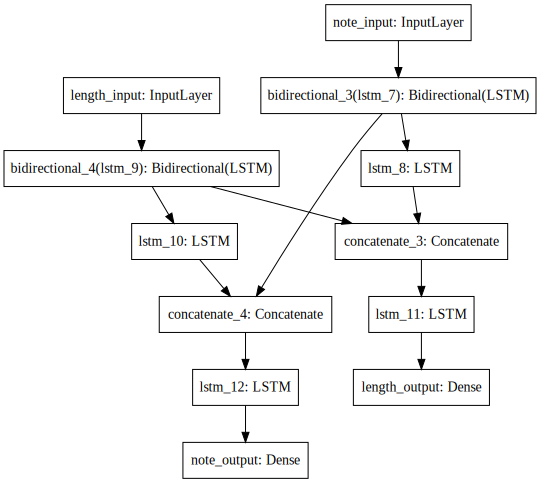

In [30]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [31]:
# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.6
	epochs_drop = 25
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [32]:
def listen_callback(epoch, logs):
    if epoch % 25 == 0 and epoch > -1: 
    # if epoch < -2:
        print('----- Generating melody after Epoch: %d' % epoch)

        start_index = 0
        for diversity in [0.5]:
            print('----- diversity:', diversity)

            current_note_phrase = notes_corpus[start_index: start_index + n_time_steps]
            current_length_phrase = length_corpus[start_index: start_index + n_time_steps]

            phrases = {'note_phrase': current_note_phrase, 'length_phrase': current_length_phrase}

            generated_notes = []
            generated_lengths = []
            generated_notes.extend(current_note_phrase)
            generated_lengths.extend(current_length_phrase)

            # model, phrases,categorized_variables, lookup_indicies, n_time_steps, diversity, n_to_generate
            for step in range(30):
                encoded_prediction = make_encoded_prediction(
                    model=model,
                    phrases=phrases,
                    categorized_variables=categorized_variables,
                    lookup_indicies=lookup_indicies,
                    n_time_steps=n_time_steps
                )

                predictions = decode_predictions(
                    encoded_prediction=encoded_prediction,
                    lookup_indicies=lookup_indicies,
                    temperature=diversity
                )

                generated_notes.append(predictions['note_prediction']) 
                generated_lengths.append(predictions['length_prediction']) 

                phrases['note_phrase'] = np.append(phrases['note_phrase'][1:], predictions['note_prediction'])
                phrases['length_phrase'] = np.append(phrases['length_phrase'][1:], predictions['length_prediction'])

            play_generated_phrase(
                generated_notes=generated_notes[10:],
                generated_lengths=generated_lengths[10:],
                player=player)

In [33]:
lrate = LearningRateScheduler(step_decay)

In [34]:
tensorboard = TensorBoard(log_dir="./logs/{}".format(datetime.datetime.now()), histogram_freq=0, write_graph=True)

In [35]:
listen_callback = LambdaCallback(on_epoch_end=listen_callback)

In [36]:
logger('TRAINING')
model.fit([note_x, length_x], [note_y, length_y],
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[
              listen_callback,
              tensorboard,
            ]
          )

          **********************************
            TRAINING
          **********************************
Epoch 1/500
1792/1836 [============================>.] - ETA: 0s - loss: 6.0321 - note_output_loss: 3.9562 - length_output_loss: 4.1518----- Generating melody after Epoch: 0
----- diversity: 0.5
63.0 | 0.6
0.0 | 1.8
57.0 | 0.46
59.0 | 0.33
61.0 | 0.84
0.0 | 1.5
56.0 | 0.51
58.0 | 0.42
60.0 | 0.7
0.0 | 1.0
0 | 0.42
0 | 0.37
58 | 0.46
0 | 0.33
0 | 0.37
0 | 0.37
0 | 0.37
0 | 0.33
0 | 0.37
0 | 0.56
0 | 0.46
0 | 0.28
0 | 0.37
0 | 0.42
0 | 0.37
0 | 0.74
0 | 0.46
65 | 0.42
0 | 0.37
0 | 0.46
59 | 0.37
0 | 0.33
0 | 0.28
0 | 0.28
0 | 0.46
0 | 0.23
0 | 0.37
0 | 0.46
0 | 0.28
0 | 0.28
1836/1836 [==============================] - 34s 18ms/step - loss: 6.0012 - note_output_loss: 3.9361 - length_output_loss: 4.1300
Epoch 2/500
1836/1836 [==============================] - 8s 4ms/step - loss: 4.6265 - note_output_loss: 3.0334 - length_output_loss: 3.1862
Epoch 3/500
1836/1836 [================

1836/1836 [==============================] - 11s 6ms/step - loss: 2.4974 - note_output_loss: 1.3063 - length_output_loss: 2.3821
Epoch 51/500
1792/1836 [============================>.] - ETA: 0s - loss: 2.4182 - note_output_loss: 1.2391 - length_output_loss: 2.3582----- Generating melody after Epoch: 50
----- diversity: 0.5
63.0 | 0.6
0.0 | 1.8
57.0 | 0.46
59.0 | 0.33
61.0 | 0.84
0.0 | 1.5
56.0 | 0.51
58.0 | 0.42
60.0 | 0.7
0.0 | 1.0
60 | 0.33
62 | 0.37
0 | 0.7
53 | 0.42
55 | 0.37
57 | 0.09
59 | 0.09
59 | 0.51
58 | 0.51
59 | 0.51
61 | 0.14
0 | 0.6
56 | 0.33
60 | 0.28
0 | 0.28
59 | 0.42
60 | 0.42
62 | 0.79
0 | 0.46
57 | 0.37
60 | 0.42
62 | 0.46
0 | 0.79
60 | 0.33
62 | 0.46
64 | 0.37
0 | 0.88
52 | 0.33
59 | 0.28
65 | 0.84
1836/1836 [==============================] - 32s 18ms/step - loss: 2.4196 - note_output_loss: 1.2405 - length_output_loss: 2.3582
Epoch 52/500
1836/1836 [==============================] - 7s 4ms/step - loss: 2.4530 - note_output_loss: 1.2706 - length_output_loss: 2.3647

1836/1836 [==============================] - 8s 4ms/step - loss: 1.0125 - note_output_loss: 0.3190 - length_output_loss: 1.3869
Epoch 100/500
1836/1836 [==============================] - 8s 4ms/step - loss: 0.8998 - note_output_loss: 0.2551 - length_output_loss: 1.2894
Epoch 101/500
1792/1836 [============================>.] - ETA: 0s - loss: 0.9726 - note_output_loss: 0.3046 - length_output_loss: 1.3361----- Generating melody after Epoch: 100
----- diversity: 0.5
63.0 | 0.6
0.0 | 1.8
57.0 | 0.46
59.0 | 0.33
61.0 | 0.84
0.0 | 1.5
56.0 | 0.51
58.0 | 0.42
60.0 | 0.7
0.0 | 1.0
54 | 0.37
56 | 0.42
58 | 1.1
0 | 1.3
63 | 0.42
65 | 0.37
67 | 1.3
69 | 0.51
0 | 0.74
62 | 0.28
64 | 0.09
65 | 0.51
66 | 0.74
0 | 1.0
65 | 0.32
67 | 0.42
69 | 0.65
0 | 1.2
62 | 0.42
64 | 0.65
66 | 0.09
0 | 1.4
64 | 0.28
66 | 0.33
67 | 1.4
0 | 1.8
50 | 0.28
52 | 0.42
54 | 0.65
0 | 0.6
1836/1836 [==============================] - 37s 20ms/step - loss: 0.9680 - note_output_loss: 0.3027 - length_output_loss: 1.3306
Epoch

1836/1836 [==============================] - 8s 4ms/step - loss: 0.1902 - note_output_loss: 0.0184 - length_output_loss: 0.3436
Epoch 149/500
1836/1836 [==============================] - 8s 4ms/step - loss: 0.2750 - note_output_loss: 0.0204 - length_output_loss: 0.5092
Epoch 150/500
1836/1836 [==============================] - 8s 4ms/step - loss: 0.2479 - note_output_loss: 0.0356 - length_output_loss: 0.4246
Epoch 151/500
1792/1836 [============================>.] - ETA: 0s - loss: 0.2733 - note_output_loss: 0.0669 - length_output_loss: 0.4129----- Generating melody after Epoch: 150
----- diversity: 0.5
63.0 | 0.6
0.0 | 1.8
57.0 | 0.46
59.0 | 0.33
61.0 | 0.84
0.0 | 1.5
56.0 | 0.51
58.0 | 0.42
60.0 | 0.7
0.0 | 1.0
54 | 0.37
56 | 0.46
58 | 0.74
0 | 0.14
60 | 0.37
62 | 0.46
64 | 0.09
65 | 0.09
66 | 0.51
65 | 0.51
67 | 0.51
0 | 0.51
54 | 0.37
56 | 0.37
58 | 0.79
0 | 0.51
60 | 0.28
62 | 0.37
64 | 0.7
0 | 0.56
63 | 0.28
65 | 0.46
66 | 0.05
65 | 0.46
66 | 0.46
0 | 0.19
57 | 0.42
59 | 0.37
61 

1836/1836 [==============================] - 7s 4ms/step - loss: 0.1155 - note_output_loss: 0.0438 - length_output_loss: 0.1433
Epoch 198/500
1836/1836 [==============================] - 7s 4ms/step - loss: 0.0326 - note_output_loss: 0.0058 - length_output_loss: 0.0538
Epoch 199/500
1836/1836 [==============================] - 7s 4ms/step - loss: 0.0272 - note_output_loss: 0.0042 - length_output_loss: 0.0460
Epoch 200/500
1836/1836 [==============================] - 7s 4ms/step - loss: 0.0229 - note_output_loss: 0.0032 - length_output_loss: 0.0394
Epoch 201/500
1792/1836 [============================>.] - ETA: 0s - loss: 0.2028 - note_output_loss: 0.0315 - length_output_loss: 0.3427----- Generating melody after Epoch: 200
----- diversity: 0.5
63.0 | 0.6
0.0 | 1.8
57.0 | 0.46
59.0 | 0.33
61.0 | 0.84
0.0 | 1.5
56.0 | 0.51
58.0 | 0.42
60.0 | 0.7
0.0 | 1.0
54 | 0.37
56 | 0.46
58 | 0.74
0 | 0.14
60 | 0.33
62 | 0.46
0 | 0.6
59 | 0.46
61 | 0.37
63 | 0.09
0 | 0.51
52 | 0.33
54 | 0.32
56 | 0.65

1836/1836 [==============================] - 7s 4ms/step - loss: 0.0062 - note_output_loss: 0.0014 - length_output_loss: 0.0096
Epoch 247/500
1836/1836 [==============================] - 7s 4ms/step - loss: 0.0053 - note_output_loss: 0.0012 - length_output_loss: 0.0082
Epoch 248/500
1836/1836 [==============================] - ETA: 0s - loss: 0.0046 - note_output_loss: 9.9740e-04 - length_output_loss: 0.007 - 7s 4ms/step - loss: 0.0046 - note_output_loss: 9.9755e-04 - length_output_loss: 0.0072
Epoch 249/500
1836/1836 [==============================] - 7s 4ms/step - loss: 0.0041 - note_output_loss: 8.6502e-04 - length_output_loss: 0.0065
Epoch 250/500
1836/1836 [==============================] - 7s 4ms/step - loss: 0.0038 - note_output_loss: 7.6190e-04 - length_output_loss: 0.0061
Epoch 251/500
1792/1836 [============================>.] - ETA: 0s - loss: 0.0034 - note_output_loss: 6.6416e-04 - length_output_loss: 0.0055----- Generating melody after Epoch: 250
----- diversity: 0.5
63.0 

KeyboardInterrupt: 

In [45]:
save_model(model, 'model')

Saved model.json and model.h5 to disk
